In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PySpin

In [19]:
spin_system = PySpin.System.GetInstance()
cam_list = spin_system.GetCameras()
iface_list = spin_system.GetInterfaces()

In [20]:
cam = cam_list.GetByIndex(0)
cam.Init()

In [21]:
cam.ExposureAuto.SetValue(PySpin.ExposureAuto_Continuous)

In [22]:
cam.ExposureAuto.SetValue(PySpin.ExposureAuto_Off)
cam.ExposureMode.SetValue(PySpin.ExposureMode_Timed)
cam.ExposureTime.SetValue(10)

In [23]:
def set_stream_mode(cam):
    """
    This function changes the stream mode. Taken from example Acquisition.py.

    :param cam: Camera to change stream mode.
    :type cam: CameraPtr
    :type nodemap_tlstream: INodeMap
    :return: True if successful, False otherwise.
    :rtype: bool
    """
    streamMode = "Socket"  # always use socket if not Windows

    result = True

    # Retrieve Stream nodemap
    nodemap_tlstream = cam.GetTLStreamNodeMap()

    # In order to access the node entries, they have to be casted to a pointer type (CEnumerationPtr here)
    node_stream_mode = PySpin.CEnumerationPtr(nodemap_tlstream.GetNode('StreamMode'))

    # The node "StreamMode" is only available for GEV cameras.
    # Skip setting stream mode if the node is inaccessible.
    if not PySpin.IsReadable(node_stream_mode) or not PySpin.IsWritable(node_stream_mode):
        return True

    # Retrieve the desired entry node from the enumeration node
    node_stream_mode_custom = PySpin.CEnumEntryPtr(node_stream_mode.GetEntryByName(streamMode))

    if not PySpin.IsReadable(node_stream_mode_custom):
        # Failed to get custom stream node
        print('Stream mode ' + streamMode + ' not available. Aborting...')
        return False

    # Retrieve integer value from entry node
    stream_mode_custom = node_stream_mode_custom.GetValue()

    # Set integer as new value for enumeration node
    node_stream_mode.SetIntValue(stream_mode_custom)

    print('Stream Mode set to %s...' % node_stream_mode.GetCurrentEntry().GetSymbolic())
    return result

import threading

class ImageEventHandler(PySpin.ImageEventHandler):
    """Class to handle image acquisition events. Based on the example ImageEvents.py.
    """

    def __init__(self):
        """
        Constructor.
        """
        super(ImageEventHandler, self).__init__()
        self._lock = threading.Lock()
        self._cond = threading.Condition(self._lock)
        self._latest_array = None
        self._frame_id = 0

    def OnImageEvent(self, image):
        if image.IsIncomplete():
            image.Release()
            return

        arr = np.array(image.GetNDArray(), dtype=np.uint16, copy=True)
        image.Release()

        with self._cond:
            self._latest_array = arr
            self._frame_id += 1
            self._cond.notify_all()

    def wait_for_new_image(self, last_id):
        """
        Block until there is a valid image, then return it as a numpy array.
        """
        with self._cond:
            while self._frame_id <= last_id:
                self._cond.wait()
            return self._latest_array, self._frame_id

In [24]:
set_stream_mode(cam)
handler = ImageEventHandler()
cam.RegisterEventHandler(handler)

In [25]:
cam.BeginAcquisition()

In [26]:
arr, id = handler.wait_for_new_image(0)
print(id)

146


(336, 336)


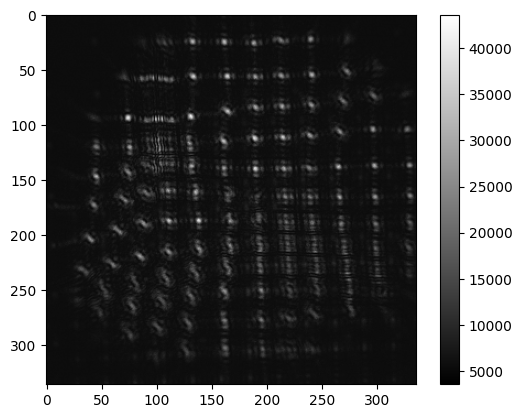

In [27]:
print(arr.shape)
plt.figure()
plt.imshow(arr, cmap='gray')
plt.colorbar()
plt.show()

In [12]:
nodemap = cam.GetNodeMap()
roi_nodes = {
        "width": PySpin.CIntegerPtr(nodemap.GetNode('Width')),
        "height": PySpin.CIntegerPtr(nodemap.GetNode('Height')),
        "offset_x": PySpin.CIntegerPtr(nodemap.GetNode('OffsetX')),
        "offset_y": PySpin.CIntegerPtr(nodemap.GetNode('OffsetY')),
    }
binning_nodes = {
        "horizontal": PySpin.CIntegerPtr(nodemap.GetNode('BinningHorizontal')),
        "vertical": PySpin.CIntegerPtr(nodemap.GetNode('BinningVertical'))
    }

In [13]:
cam.EndAcquisition()

In [14]:
node_pixel_format = PySpin.CEnumerationPtr(nodemap.GetNode("PixelFormat"))

In [15]:
entry = node_pixel_format.GetEntryByName("Mono16")
pixel_format_value = entry.GetValue()
node_pixel_format.SetIntValue(pixel_format_value)

In [55]:
print(roi_nodes["height"].GetValue())
print(roi_nodes["width"].GetValue())
print(roi_nodes["offset_x"].GetValue())
print(roi_nodes["offset_y"].GetValue())

336
336
1052
844


In [16]:
roi_nodes["height"].SetValue(336)
roi_nodes["width"].SetValue(336)
roi_nodes["offset_x"].SetValue(1052)
roi_nodes["offset_y"].SetValue(844)

In [ ]:
roi_nodes["offset_x"].SetValue(1052)
roi_nodes["offset_y"].SetValue(844)

In [ ]:
roi_nodes["width"].SetValue(336) #256

In [27]:
b = 1

roi_nodes["height"].SetValue(int(336 / b))
roi_nodes["width"].SetValue(int(336 / b))
roi_nodes["offset_x"].SetValue(int(1052 / b))
roi_nodes["offset_y"].SetValue(int(844 / b))

binning_nodes["vertical"].SetValue(b)

In [31]:
roi_nodes["width"].SetValue(7)

SpinnakerException: Spinnaker: GenICam::OutOfRangeException= Value = 7 must be equal or greater than Min = 16. : OutOfRangeException thrown in node 'Width' while calling 'Width.SetValue()' (file 'IntegerT.h', line 79) [-2002]

In [20]:
for node in binning_nodes:
    if not PySpin.IsAvailable(binning_nodes[node]):
        print("Node %s not available." % node)
    elif not PySpin.IsWritable(binning_nodes[node]):
        print("Node %s not writable." % node)

Node horizontal not writable.


In [28]:
cam.EndAcquisition()
cam.DeInit()

In [29]:
del cam

In [30]:
cam_list.Clear()
iface_list.Clear()
spin_system.ReleaseInstance()